<a href="https://colab.research.google.com/github/sirajghassel/Fine-Tuning-VLM-Qwen2-VL-7B/blob/main/Fine_Tuning_VLM_(Qwen2_VL_7B).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 1: Inference

In [3]:
!pip install -U -q git+https://github.com/huggingface/trl.git bitsandbytes peft qwen-vl-utils trackio

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.7/865.7 kB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 60.0 MB/s eta 0:00:00


In [4]:
from huggingface_hub import notebook_login

notebook_login()

In [5]:
system_message = """You are a Vision Language Model specialized in interpreting visual data from chart images.
Your task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.
The charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.
Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary."""

In [6]:
def format_data(sample):
    return {
      "images": [sample["image"]],
      "messages": [

          {
              "role": "system",
              "content": [
                  {
                      "type": "text",
                      "text": system_message
                  }
              ],
          },
          {
              "role": "user",
              "content": [
                  {
                      "type": "image",
                      "image": sample["image"],
                  },
                  {
                      "type": "text",
                      "text": sample['query'],
                  }
              ],
          },
          {
              "role": "assistant",
              "content": [
                  {
                      "type": "text",
                      "text": sample["label"][0]
                  }
              ],
          },
      ]
      }

In [7]:
from datasets import load_dataset

dataset_id = "HuggingFaceM4/ChartQA"
train_dataset, eval_dataset, test_dataset = load_dataset(dataset_id, split=['train[:10%]', 'val[:10%]', 'test[:10%]'])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/852 [00:00<?, ?B/s]

data/train-00000-of-00003-49492f364babfa(…):   0%|          | 0.00/219M [00:00<?, ?B/s]

data/train-00001-of-00003-7302bae5e425bb(…):   0%|          | 0.00/311M [00:00<?, ?B/s]

data/train-00002-of-00003-194c9400785577(…):   0%|          | 0.00/315M [00:00<?, ?B/s]

data/val-00000-of-00001-0f11003c77497969(…):   0%|          | 0.00/50.2M [00:00<?, ?B/s]

data/test-00000-of-00001-e2cd0b7a0f9eb20(…):   0%|          | 0.00/68.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/28299 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/1920 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2500 [00:00<?, ? examples/s]

In [ ]:
train_dataset

Dataset({
    features: ['image', 'query', 'label', 'human_or_machine'],
    num_rows: 2830
})

In [13]:
train_dataset = [format_data(sample) for sample in train_dataset]
eval_dataset = [format_data(sample) for sample in eval_dataset]
test_dataset = [format_data(sample) for sample in test_dataset]

In [ ]:
train_dataset[200]

{'images': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=308x369>],
 'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': 'You are a Vision Language Model specialized in interpreting visual data from chart images.\nYour task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.\nThe charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.\nFocus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary.'}]},
  {'role': 'user',
   'content': [{'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=308x369>},
    {'type': 'text',
     'text': 'Is the rightmost value of light brown graph 58?'}]},
  {'role': 'assistant', 'content': [{'type': 'text', 'text': 'No'}]}]}

In [8]:
import torch
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor

model_id = "Qwen/Qwen2-VL-7B-Instruct"

In [ ]:
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    dtype=torch.bfloat16,
)

processor = Qwen2VLProcessor.from_pretrained(model_id)

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

In [ ]:
train_dataset[0]

{'images': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x359>],
 'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': 'You are a Vision Language Model specialized in interpreting visual data from chart images.\nYour task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.\nThe charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.\nFocus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary.'}]},
  {'role': 'user',
   'content': [{'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x359>},
    {'type': 'text', 'text': 'Is the value of Favorable 38 in 2015?'}]},
  {'role': 'assistant', 'content': [{'type': 'text', 'text': 'Yes'}]}]}

In [ ]:
train_dataset[0]['messages'][1:2]

[{'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x359>},
   {'type': 'text', 'text': 'Is the value of Favorable 38 in 2015?'}]}]

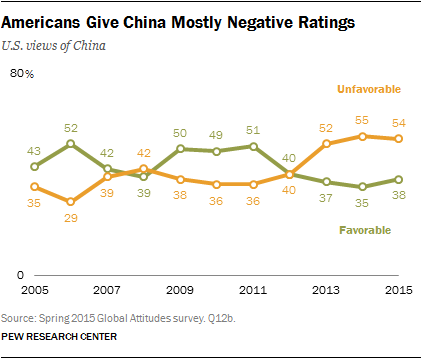

In [ ]:
train_dataset[0]['images'][0]

In [ ]:
train_dataset[0]['messages']

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a Vision Language Model specialized in interpreting visual data from chart images.\nYour task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.\nThe charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.\nFocus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x359>},
   {'type': 'text', 'text': 'Is the value of Favorable 38 in 2015?'}]},
 {'role': 'assistant', 'content': [{'type': 'text', 'text': 'Yes'}]}]

In [16]:
from qwen_vl_utils import process_vision_info

def generate_text_from_sample(model, processor, sample, max_new_tokens=1024, device="cuda"):
    # Prepare the text input by applying the chat template
    text_input = processor.apply_chat_template(
        sample['messages'][1:2],  # Use the sample without the system message
        tokenize=False,
        add_generation_prompt=True
    )

    # Process the visual input from the sample
    image_inputs, _ = process_vision_info(sample['messages'])

    # Prepare the inputs for the model
    model_inputs = processor(
        text=[text_input],
        images=image_inputs,
        return_tensors="pt",
    ).to(device)  # Move inputs to the specified device

    # Generate text with the model
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    # Decode the output text
    output_text = processor.batch_decode(
        trimmed_generated_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )

    return output_text[0]  # Return the first decoded output text

In [ ]:
output = generate_text_from_sample(model, processor, train_dataset[0])
output

'No, the value of Favorable is not 38 in 2015. According to the chart, the value of Favorable in 2015 is 35.'

## Part 2: Fine Tuning

In [ ]:
import gc
import time

def clear_memory():
    # Delete variables if they exist in the current global scope
    if 'inputs' in globals(): del globals()['inputs']
    if 'model' in globals(): del globals()['model']
    if 'processor' in globals(): del globals()['processor']
    if 'trainer' in globals(): del globals()['trainer']
    if 'peft_model' in globals(): del globals()['peft_model']
    if 'bnb_config' in globals(): del globals()['bnb_config']
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

clear_memory()

GPU allocated memory: 0.01 GB
GPU reserved memory: 0.02 GB


In [ ]:
from transformers import BitsAndBytesConfig

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config
)
processor = Qwen2VLProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
from peft import LoraConfig, get_peft_model

# Configure LoRA
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=8,
    bias="none",
    target_modules=["q_proj", "v_proj"],
    task_type="CAUSAL_LM",
)

# Apply PEFT model adaptation
peft_model = get_peft_model(model, peft_config)

# Print trainable parameters
peft_model.print_trainable_parameters()

trainable params: 2,523,136 || all params: 8,293,898,752 || trainable%: 0.0304


In [ ]:
from trl import SFTConfig

# Configure training arguments
training_args = SFTConfig(
    output_dir="qwen2-7b-instruct-trl-sft-ChartQA",  # Directory to save the model
    num_train_epochs=3,  # Number of training epochs
    per_device_train_batch_size=4,  # Batch size for training
    per_device_eval_batch_size=4,  # Batch size for evaluation
    gradient_accumulation_steps=8,  # Steps to accumulate gradients
    gradient_checkpointing_kwargs={"use_reentrant": False},  # Options for gradient checkpointing
    max_length=None,
    # Optimizer and scheduler settings
    optim="adamw_torch_fused",  # Optimizer type
    learning_rate=2e-4,  # Learning rate for training
    # Logging and evaluation
    logging_steps=10,  # Steps interval for logging
    eval_steps=10,  # Steps interval for evaluation
    eval_strategy="steps",  # Strategy for evaluation
    save_strategy="steps",  # Strategy for saving the model
    save_steps=20,  # Steps interval for saving
    # Mixed precision and gradient settings
    bf16=True,  # Use bfloat16 precision
    max_grad_norm=0.3,  # Maximum norm for gradient clipping
    warmup_ratio=0.03,  # Ratio of total steps for warmup
    # Hub and reporting
    push_to_hub=True,  # Whether to push model to Hugging Face Hub
    report_to="trackio",  # Reporting tool for tracking metrics
)

In [ ]:
import trackio

trackio.init(
    project="qwen2-7b-instruct-trl-sft-ChartQA",
    name="qwen2-7b-instruct-trl-sft-ChartQA",
    config=training_args,
    space_id=training_args.output_dir + "-trackio"
)

* Trackio project initialized: qwen2-7b-instruct-trl-sft-ChartQA
* Trackio metrics will be synced to Hugging Face Dataset: codingdawg/qwen2-7b-instruct-trl-sft-ChartQA-trackio-dataset
* Creating new space: https://huggingface.co/spaces/codingdawg/qwen2-7b-instruct-trl-sft-ChartQA-trackio
* View dashboard by going to: https://codingdawg-qwen2-7b-instruct-trl-sft-ChartQA-trackio.hf.space/


* Created new run: qwen2-7b-instruct-trl-sft-ChartQA


In [ ]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    peft_config=peft_config,
    processing_class=processor,
)

/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [ ]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


* Trackio project initialized: huggingface
* Trackio metrics will be synced to Hugging Face Dataset: codingdawg/trackio-dataset
* Creating new space: https://huggingface.co/spaces/codingdawg/trackio
* View dashboard by going to: https://codingdawg-trackio.hf.space/


* Created new run: codingdawg-1760391255


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
10,16.705500,16.471075,2.639723,168709.000000,0.094576
20,14.382700,11.869643,6.287330,336118.000000,0.100126
30,9.355300,7.873833,7.869074,505921.000000,0.099945
40,7.411600,7.262779,7.617129,677163.000000,0.106039
50,7.053600,6.968050,7.356730,848791.000000,0.132509
60,6.731000,6.689199,7.017868,1018925.000000,0.172355
70,6.409200,6.522439,6.804810,1181787.000000,0.197161
80,6.451100,6.458904,6.718415,1360714.000000,0.201063
90,6.222900,6.427120,6.680673,1511764.000000,0.201294
100,6.283500,6.403519,6.645555,1682798.000000,0.201385


* Run finished. Uploading logs to Trackio (please wait...)


TrainOutput(global_step=267, training_loss=7.13313076290745, metrics={'train_runtime': 3452.6313, 'train_samples_per_second': 2.459, 'train_steps_per_second': 0.077, 'total_flos': 3.203335387407667e+17, 'train_loss': 7.13313076290745, 'entropy': 6.139447597356943, 'num_tokens': 4487421.0, 'mean_token_accuracy': 0.24792743990054497, 'epoch': 3.0})

In [10]:
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    dtype=torch.bfloat16,
)

processor = Qwen2VLProcessor.from_pretrained(model_id)

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

In [11]:
adapter_path = "codingdawg/qwen2-7b-instruct-trl-sft-ChartQA"
model.load_adapter(adapter_path)

adapter_config.json:   0%|          | 0.00/859 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/10.1M [00:00<?, ?B/s]

In [14]:
train_dataset[0]['messages'][:2]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a Vision Language Model specialized in interpreting visual data from chart images.\nYour task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.\nThe charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.\nFocus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x359>},
   {'type': 'text', 'text': 'Is the value of Favorable 38 in 2015?'}]}]

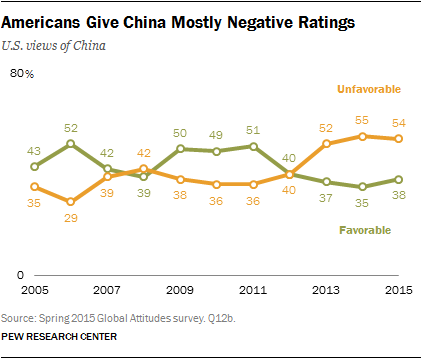

In [15]:
train_dataset[0]['images'][0]

In [17]:
output = generate_text_from_sample(model, processor, train_dataset[0])
output

'No, the value of Favorable is not 38 in 2015. According to the graph, the value of Favorable in 2015 is 38.'

In [19]:
!pip freeze > requirements.txt

In [18]:
!python --version

Python 3.12.12
